# Take Home Miderm - Fall 2022

In this take home midterm the goal is to implement a **Turkish Sentiment Analyser** using Vector Space model.

In the context of this midterm, dentiment analysis is considered as a binary text classification.

## Dataset

The dataset is taken from https://www.win.tue.nl/~mpechen/projects/smm/, where the Turkish Movie Reviews data set is publicly avaliable: https://www.win.tue.nl/~mpechen/projects/smm/Turkish_Movie_Sentiment.zip.



## Dataset Preperation
---

The following code piece downloads the zip file, and then unzip it into the current directory.

In [ ]:
!curl https://www.win.tue.nl/~mpechen/projects/smm/Turkish_Movie_Sentiment.zip -o ./Turkish_Movie_Sentiment.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  520k  100  520k    0     0   388k      0  0:00:01  0:00:01 --:--:--  388k


In [ ]:
!ls

sample_data  Turkish_Movie_Sentiment.zip


In [ ]:
!unzip /content/Turkish_Movie_Sentiment.zip -d /content

Archive:  /content/Turkish_Movie_Sentiment.zip
  inflating: /content/tr_polarity.neg  
  inflating: /content/tr_polarity.pos  


In [ ]:
!ls -l

total 2020
drwxr-xr-x 1 root root   4096 Nov 14 14:32 sample_data
-rw-r--r-- 1 root root 766282 Feb 22  2013 tr_polarity.neg
-rw-r--r-- 1 root root 755066 Feb 22  2013 tr_polarity.pos
-rw-r--r-- 1 root root 533335 Nov 16 17:00 Turkish_Movie_Sentiment.zip


## Dataset Content
---

The zip file contains two txt file, with a *.neg extension and a *.pos extension, repectively. Here, "pos" stands for positive movie reviews and "neg" for negative movie reviews.

In each file, every line has one review, and hence 5331 reviews in total for each category.

In [ ]:
!wc -l ./tr_polarity.neg

5331 ./tr_polarity.neg


In [ ]:
!wc -l ./tr_polarity.pos

5331 ./tr_polarity.pos


## Read reviews from files

In [ ]:
# Positive Reviews
import os;
with open("./tr_polarity.pos", 'rb') as f:
     reviews_pos = f.read().decode('iso-8859-9').replace('\r', '');

In [ ]:
list_pos = reviews_pos.split('\n');

In [ ]:
# Negative Reviews
with open("./tr_polarity.neg", 'rb') as f:
     reviews_neg = f.read().decode('iso-8859-9').replace('\r', '');

In [ ]:
list_neg = reviews_neg.split('\n');

# Model Construction and Evaluation

---

In this midterm, you are asked to fullfil the following conditions given below by implementing the neccessary NLP tasks:

**Assumption:** Each review is a document as the Vector Space Model states.

**Assumption:**  Each review category, **pos** and **neg**, is a class/cluster.

1. Divide the dataset into two parts, one of which holds the 90% and the other one of which holds the remaining 10%. Call the former as **training** dataset, and the latter as the **test** dataset. This can be done in 10 ways and results in 10 different non-overlappling pairs of train-test. For each of the 10 pairs, repeat the following steps. See for further instructions and pseudo code[cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation).

> 1.1. Build a Model using the **training** dataset.

> 1.2. Using cosine similarity measure, classify each review in the **test** dataset, such that, 

>  * if the review has a smilarity score to the reviews in **pos** training dataset, then mark the review as **pos**; 
  * otherwise, mark it as **neg**

> 1.3. Count the number of *true-positives*, *false-positives*, *true-negatives* and *false-negatives*. 

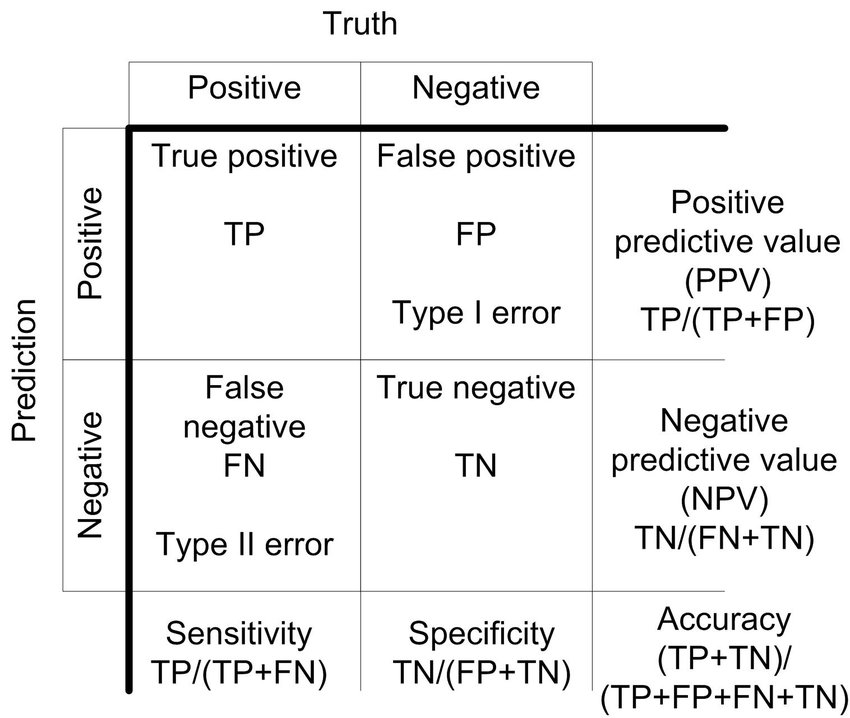

### _

> 1.4. Calculate **Accuracy** for the current train-test pair.

2. After calculating 10 accuracy scores, take the average (mean), and report it as the final performance score.

3. Review your solution, observe and give a list of possible improvements in your first implementation using examples and demonstrations.

4. From the list of improvements, pick the one that is highly likely to impact most to the accuracy, and make that changes in your implementation, and repeat the steps from 3. item (including). Do not make the changes in place, do the new implementation from scratch continuing the notebook with new cells.

5. Compare the two mean accuracy scores, and give a short conclusion.

## **Step 1: Preperation of test environment**


> Sub-Step 1: Create document vectors. In document vectors, you may use one-hot model or TF (Term-Frequency) model. Trivial approach is one-hot, so try it first.

> Sub-Step 2: Divide each document list, **pos** and **neg**, simultenously, into train and test splits, at 90 and 10 percent of the list.

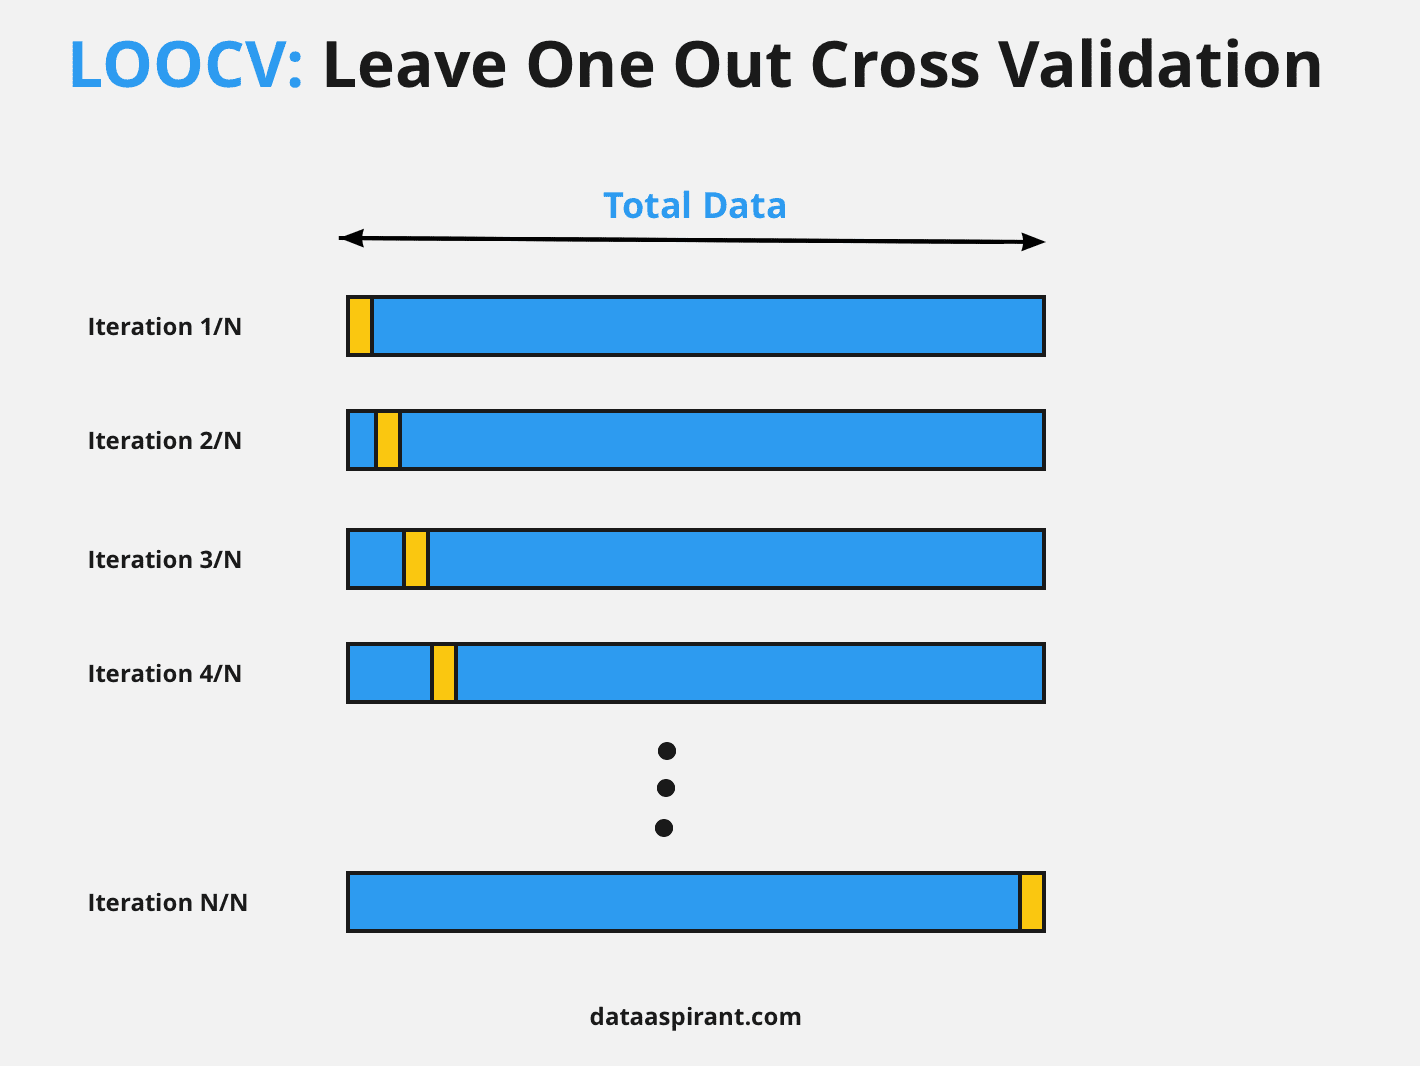

We will be using sqrt() function from math in further steps, so we need to import math

In [ ]:
import math

We check whether positive and negative reviews are in the same length or not

In [ ]:
assert(len(list_pos) == len(list_neg))

### Dataset slicing (creates partition boundries)

This is the dataset slicing function, which we will be using in k-fold cross validation step

In [ ]:
def dataset_slicing():
  data_size = len(list_pos);
  test_size = round(data_size * 0.1); # 10% of whole dataset for each round.
  test_index = [(x * test_size, x * test_size + test_size) for x in range(10)];
  # Correction: include remaining reviews, if any, to the last index pair
  test_index[9] = (test_index[9][0], data_size);
  print("Data size = %d, Test Size = %d, Last Index = %d" % (data_size, test_size, test_index[-1][1]));
  print("Dataset slices for testing: %s\n\n" % test_index)
  return test_index

We call dataset_slicing() to create partition boundries.

In [ ]:
test_index = dataset_slicing()

Data size = 5332, Test Size = 533, Last Index = 5332
Dataset slices for testing: [(0, 533), (533, 1066), (1066, 1599), (1599, 2132), (2132, 2665), (2665, 3198), (3198, 3731), (3731, 4264), (4264, 4797), (4797, 5332)]




### Dataset splitting

Utility function for dataset splitting, works by partitioning data as train-test with 9/1 ratio, choosing which index is test

In [ ]:
def prepare(data,i):
  data_test  = data[test_index[i][0]:test_index[i][1]];
  data_train = data[0:test_index[i][0]] + data[test_index[i][1]:len(data)];
  return (data_test,data_train)

We call prepare() function to create test/train datasets for positive/negative reviews.  

In [ ]:
(pos_test,pos_train) = prepare(list_pos, 0)
(neg_test,neg_train) = prepare(list_neg, 0)

print("Pos test size: %d, \n Last item : %s" % (len(pos_test), pos_test[-1]) )
print("Pos train size: %d, \n Last item : %s" % (len(pos_train), pos_train[0]) )

print("Neg test size: %d, \n Last item : %s" % (len(neg_test), neg_test[-1]) )
print("Neg train size: %d, \n Last item : %s" % (len(neg_train), neg_train[0]) )

Pos test size: 533, 
 Last item : romantik-komedi severler icin cok iyi bi secim olur cok sicak eglenceli komik ve iyi oyunculukla birlesince guzel bi film cikmis julia roberts yine oyunculuk dersi vermis tavsiye ederim. 
Pos train size: 4799, 
 Last item : çok fazla eglenceli bir romantik-komedi idi. en fazla gösterimde kalan, filmlerden birisi ayrica.... 
Neg test size: 533, 
 Last item : kesinlikle iyi bir psikoloji gerilim bekleyenlerin gerilimlerini karsilamayan bol kliseli vasatin bile altinda bir film filmin tek bir artisi var oda john cusack in müthis oyunculugu bundan öte 1408 de hiç bir sey yok. . 
Neg train size: 4799, 
 Last item : bu filmin neresini begendiniz anlamadim saçma sapan bi gerilim filmi,sadece geriliyosunuz ama belli bi konu yok abuk subuk bir hikaye.kimseye tavsiye etmem. 


### Tokenization
Now, we tokenize the test/train datasets for positive/negative reviews by using split() method. Tokens for test datasets will be used in classification part, but the tokens for train datasets will be used for vocabulary generation.

In [ ]:
token_train_pos = [ doc.split() for doc in pos_train];
token_test_pos = [ doc.split() for doc in pos_test];
token_train_neg = [ doc.split() for doc in neg_train];
token_test_neg = [ doc.split() for doc in neg_test];

### Flattening
Flattening is used for creating a list that contains every word in positive reviews and negative reviews seperately.

In [ ]:
tokens_pos_flat = [x for X in token_train_pos for x in X]
tokens_neg_flat = [x for X in token_train_neg for x in X]

tokens_pos_flat_test = [x for X in token_test_pos for x in X]
tokens_neg_flat_test = [x for X in token_test_neg for x in X]

### Vocabulary generation
We generate vocabularies for positive and negative reviews using the flattened train data.

In [ ]:
vocab_pos = set(tokens_pos_flat)
vocab_neg = set(tokens_neg_flat)
print("Size of pos vocabulary %d" % len(vocab_pos) )
print("Size of neg vocabulary %d" % len(vocab_neg) )

Size of pos vocabulary 22606
Size of neg vocabulary 24282


## **Step 1.1: Build the Model using the training dataset.**


Using the training data split (i.e. 90% of the dataset), figure out a representation scheme, model for each class. 

Explain it briefly.

### Document Vectors

Here, we create two different types of dictionaries for both positive and negative vocabularies, which will be used for creating document vectors. Finally, those document vectors will be appended in different lists, which will be used for comparing test documents.

In [ ]:
term2idx_pos = {};
for idx, token in enumerate(vocab_pos):
  term2idx_pos.update({token:idx})

term2idx_neg = {};
for idx, token in enumerate(vocab_neg):
  term2idx_neg.update({token:idx})

term2idx_pos_test = {};
for idx, token in enumerate(tokens_pos_flat_test):
  term2idx_pos_test.update({token:idx})

term2idx_neg_test = {};
for idx, token in enumerate(tokens_neg_flat_test):
  term2idx_neg_test.update({token:idx})

In [ ]:
idx2term_pos = {};
for term in term2idx_pos:
  idx = term2idx_pos.get(term);
  idx2term_pos.update({idx:term});

idx2term_neg = {};
for term in term2idx_neg:
  idx = term2idx_neg.get(term);
  idx2term_neg.update({idx:term});

In [ ]:
test = [[0 for idx in idx2term_pos] for doc in pos_train];
print(test)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4799

In [ ]:
# # list of document vectors, via list comprehension
docvec_list_pos = [[1 if doc.find(idx2term_pos.get(idx)) > -1 else 0 for idx in idx2term_pos] for doc in pos_train];
docvec_list_neg = [[1 if doc.find(idx2term_neg.get(idx)) > -1 else 0 for idx in idx2term_neg] for doc in neg_train];

In [ ]:
# # list of test document vectors, via list comprehension
docvec_list_pos_test = [[0 for idx in idx2term_pos] for doc in pos_test];
for doc_vec, doc_tokens in zip(docvec_list_pos_test, token_test_pos):
  for token in doc_tokens:
    doc_vec[term2idx_pos_test[token]] = 1;

docvec_list_neg_test = [[0 for idx in idx2term_neg] for doc in neg_test];
for doc_vec, doc_tokens in zip(docvec_list_neg_test, token_test_neg):
  for token in doc_tokens:
    doc_vec[term2idx_neg_test[token]] = 1;

### Creating a Representative Vector

Here, we had two choices mainly. One of them is to compare every single test vector with every document vector in whole document vector list, and the other one is to compare every single test vector with a single vector created by averaging every vector in the document vector list (a representative vector).

Since the runtime would be much greater in the first option, I have chosen the latter approach.

In [ ]:
def create_representative_vector(vec_list):
  doc_rep_vec = len(vec_list[0])*[0]
  for a in vec_list:
    for idx2, b in enumerate(a):
      doc_rep_vec[idx2] = doc_rep_vec[idx2] + b
  for idx, i in enumerate(doc_rep_vec):
    doc_rep_vec[idx] = i/len(vec_list)
  return(doc_rep_vec)

In [ ]:
pos_doc_rep_vec = create_representative_vector(docvec_list_pos)
neg_doc_rep_vec = create_representative_vector(docvec_list_neg)

## **Step 1.2: Classify each review in the test split**


Using the **Model** you have decided, take each review from both **pos** and **neg** class, and compare with the **pos** class representation in your **Model**, and also with the **new** class representation, using Cosine Similarity measure.

Repeat the comparison for each review until all reviews in the test split run out. 

Record the result of each comparison, for instance, as a pair like 

"1:1" which stands for true-positive: that is, your prediction is pos and the review is from **pos** test split. 

"1:0" would then stands for "false positive": that is, your predection is **pos** (1) and review is from **neg** test split (0). 

"0:1" is "false negative": your prediction is negative (0) and review is from **pos** test split (1).

"0:0" is "true negative": your prediction is negative (0) and review is from **neg** test set (0).

### Cosine Similarity

Here, we define cosine similarity function that measures the similarity between two vectors. Output will be in between 0 and 1;
*  0 meaning no similarity,
*  1 meaning perfect similarity.

In [ ]:
def CosineSimilarity(x, y): 
  rep = []
  for a in range (len(x)):
    for b in range (a,len(y)):
      rep.append(x[a]*y[b])
      break
  numerator=sum(rep)
  denominator = math.sqrt(sum([a*a for a in x]))*math.sqrt(sum([a*a for a in y]))
  return numerator/(denominator+1)

### Classification

In this final step, we classify reviews represented as vectors by checking their similarities with representative vectors of positive vocabulary vector and negative vocabulary vector. The similarity score that is bigger decides the class of the review as a prediction. Then, we append these predictions as:

*  "1:1" if both the real value and the prediction is positive (True Positive),

*  "0:1" if the real value is negative and the prediction is positive (False Positive),

*  "1:0" if the real value is positive and the prediction is negative (False Negative),

*  "0:0" if both the real value and the prediction is negative (True Negative)

In [ ]:
def classification(docvec_list_test, pos_neg):
  result_list = []
  for idx, i in enumerate(docvec_list_test): ## (docvec_list_pos_test)
    pos_ratio = CosineSimilarity(pos_doc_rep_vec,i)
    neg_ratio = CosineSimilarity(neg_doc_rep_vec,i)
    if pos_ratio>neg_ratio:
      result_list.append(["1:%d"%pos_neg, idx]) ## (1)
    else:
      result_list.append(["0:%d"%pos_neg, idx]) ## (1)
  return(result_list)

result_list_final = classification(docvec_list_pos_test,1) + classification(docvec_list_neg_test,0)

### Accuracy Calculation

Accuracy is calculated by the division of the count of true predicted values by the count of all predictions.

In [ ]:
def accuracy_calculation(result_list):
  TP, FN, FP, TN = 0, 0, 0, 0
  for result in result_list:
    if result[0] == ("1:1"):
      TP+=1
    elif result[0] == ("0:1"):
      FN+=1
    elif result[0] == ("1:0"):
      FP+=1
    else:
      TN+=1


  print("TP : %d\nFP : %d\nFN : %d\nTN : %d\n" % (TP, FP, FN, TN) )
  print("Accuracy : " , ((TP + TN)/(TP + TN + FP + FN)), "\n\n")
  return ((TP + TN)/(TP + TN + FP + FN))

accuracy_calculation(result_list_final)

TP : 265
FP : 253
FN : 268
TN : 280

Accuracy :  0.5112570356472795 




0.5112570356472795

The accuracy is much worse than usually expected, but maybe this is an exception. We will understand better when we apply 10-fold cross validation.

### Checking False Predictions

We created this function to check the reviews that cause false predictions if there are any. This could help us while trying to understand why the prediction is faulty.

In [ ]:
def falsePredictions(result_list):
  fPreds = []
  for result in result_list:
    if result[0] == ("0:1"):
      fPreds.append([pos_test[result[1]],"FN"])
    elif result[0] == ("1:0"):
      fPreds.append([pos_test[result[1]],"FP"])


false_predictions = falsePredictions(result_list_final)

## **Step 1.3 and 1.4: Calculate Accuracy score for the 10 pairs of train-test split.**

### k-fold Cross Validation

Here, we calculate accuracy scores for every 10 different variation of partitioned datasets. After this calculation, an average accuracy will be calculated, which can be interpreted as the performance of our model.

In [ ]:
test_index = dataset_slicing();

accuracy_list  = []
false_predictions = []
for i in range(0,10):
  # preparing test train datasets
  (pos_test,pos_train) = prepare(list_pos, i)
  (neg_test,neg_train) = prepare(list_neg, i)

  # preparing tokens
  token_train_pos = [ doc.split() for doc in pos_train];
  token_test_pos = [ doc.split() for doc in pos_test];
  token_train_neg = [ doc.split() for doc in neg_train];
  token_test_neg = [ doc.split() for doc in neg_test];

  # preparing vocabularies for positive and negative reviews
  tokens_pos_flat = [x for X in token_train_pos for x in X];
  vocab_pos = set(tokens_pos_flat);
  
  tokens_neg_flat = [x for X in token_train_neg for x in X];
  vocab_neg = set(tokens_neg_flat);

  # Flattening test tokens
  tokens_pos_flat_test = [x for X in token_test_pos for x in X]
  tokens_neg_flat_test = [x for X in token_test_neg for x in X]

  # preparing term to index dictionaries for positive and negative reviews
  term2idx_pos = {};
  for idx, token in enumerate(vocab_pos):
    term2idx_pos.update({token:idx})

  term2idx_neg = {};
  for idx, token in enumerate(vocab_neg):
    term2idx_neg.update({token:idx})

  term2idx_pos_test = {};
  for idx, token in enumerate(tokens_pos_flat_test):
    term2idx_pos_test.update({token:idx})
  
  term2idx_neg_test = {};
  for idx, token in enumerate(tokens_neg_flat_test):
    term2idx_neg_test.update({token:idx})

  # preparing index to term dictionaries for positive and negative reviews
  idx2term_pos = {};
  for term in term2idx_pos:
    idx = term2idx_pos.get(term);
    idx2term_pos.update({idx:term});

  idx2term_neg = {};
  for term in term2idx_neg:
    idx = term2idx_neg.get(term);
    idx2term_neg.update({idx:term});

  # # list of document vectors, via list comprehension
  docvec_list_pos_train = [[1 if doc.find(idx2term_pos.get(idx)) > -1 else 0 for idx in idx2term_pos] for doc in pos_train];
  docvec_list_neg_train = [[1 if doc.find(idx2term_neg.get(idx)) > -1 else 0 for idx in idx2term_neg] for doc in neg_train];

  # # list of test document vectors
  docvec_list_pos_test = [[0]*len(vocab_pos) for doc in pos_test];
  for doc_vec, doc_tokens in zip(docvec_list_pos_test, token_test_pos):
    for token in doc_tokens:
      doc_vec[term2idx_pos_test[token]] = 1;

  docvec_list_neg_test = [[0]*len(vocab_neg) for doc in neg_test];
  for doc_vec, doc_tokens in zip(docvec_list_neg_test, token_test_neg):
    for token in doc_tokens:
      doc_vec[term2idx_neg_test[token]] = 1;

  # creating a representative vector for both positive and negative reviews
  pos_doc_rep_vec = create_representative_vector(docvec_list_pos_train);
  neg_doc_rep_vec = create_representative_vector(docvec_list_neg_train);

  # classifying all test data
  result_list_final = classification(docvec_list_pos_test,1) + classification(docvec_list_neg_test,0);

  # calculating accuracy
  print("Accuracy of iteration ",i+1)
  accuracy_temp = accuracy_calculation(result_list_final);
  accuracy_list.append(accuracy_temp)
  fPreds = falsePredictions(result_list_final)
  false_predictions.append(fPreds)

Data size = 5332, Test Size = 533, Last Index = 5332
Dataset slices for testing: [(0, 533), (533, 1066), (1066, 1599), (1599, 2132), (2132, 2665), (2665, 3198), (3198, 3731), (3731, 4264), (4264, 4797), (4797, 5332)]


Accuracy of iteration  1
TP : 265
FP : 253
FN : 268
TN : 280

Accuracy :  0.5112570356472795 


Accuracy of iteration  2
TP : 252
FP : 206
FN : 281
TN : 327

Accuracy :  0.5431519699812383 


Accuracy of iteration  3
TP : 352
FP : 299
FN : 181
TN : 234

Accuracy :  0.549718574108818 


Accuracy of iteration  4
TP : 164
FP : 237
FN : 369
TN : 296

Accuracy :  0.43151969981238275 


Accuracy of iteration  5
TP : 272
FP : 211
FN : 261
TN : 322

Accuracy :  0.5572232645403377 


Accuracy of iteration  6
TP : 209
FP : 237
FN : 324
TN : 296

Accuracy :  0.47373358348968103 


Accuracy of iteration  7
TP : 332
FP : 268
FN : 201
TN : 265

Accuracy :  0.5600375234521576 


Accuracy of iteration  8
TP : 287
FP : 242
FN : 246
TN : 291

Accuracy :  0.5422138836772983 


Accuracy of 

In [ ]:
mean_accuracy = sum(accuracy_list)/len(accuracy_list)
print("Our mean accuracy is ",mean_accuracy)

Our mean accuracy is  0.5201723623993969


## **Step 2: Report the Performance of the Current Approach**

We can see that the average accuracy is 0.52, which is almost the worst case scenario (tossing a coin). Therefore, we definitely have room for improvement. Possible solutions are listed below.

## **Step 3: List of Improvement Points**

In order to improve our model, we can change some steps. Some of our possible solutions are listed below:

1.   We can improve tokenization, hence the model.
2.   We can use stop-word removal.
3.   We can use Term Frequency Approach instead of OHE (One Hot Encoding) Approach.
4.   We can calculate the similarity by comparing every single test vector with every document vector in whole document vector list instead of comparing every single test vector with a single vector created by averaging every vector in the document vector list (a representative vector).


I will be trying to improve the model by applying the solutions 1, 2 and 3, which are **tokenization improvement**, **stop-word removal** and **Term Frequency Approach**.

## **Step 4: Take one of the Improvements and Implement.**

### Step 1: Improved Model

Implement 

> Step 1 through 1.1, 1.2, 1.3 and 1.4. below

I will be implementing a custom tokenization, therefore I need to import re.

In [ ]:
import re
# New Tokenization
def removePuncts(data):
  return([ re.findall(r"[\w]+|[!*][\"*][#*][$*][%*][&*][\\*]['*][(*][)*][\**][+*][,*][-*][.*][/*][:*][;*][<*][=*][>*][?*][@*][^*][_*][`*][{*][|*][}*][~*][\[*][\]*]", doc) for doc in data])

def lowerTokens(temp):
  tokensListList = []
  for i in temp:
    tokensList = []
    for j in i:
      tokensList.append(j.lower())
    tokensListList.append(tokensList)
  return(tokensListList)

def customTokenization(dataset):
  return(lowerTokens(removePuncts(dataset)))

In here, the punctuations in Turkish Language are considered and therefore defined as:

!  "  #  $  %  &  \  '  (  )  *  +  ,  -  .  /  :  ;  <  =  >  ?  @  ^  _  `  {  |  }  ~  [  ]

used in any number (such as .. or ...).

In [ ]:
# Creating partition indexes
test_index = dataset_slicing();

# Splitting datasets as train and test
(pos_test,pos_train) = prepare(list_pos, 0)
(neg_test,neg_train) = prepare(list_neg, 0)

################################################################################
# IMPROVEMENT ON TOKENIZATION (hopefully)
token_train_pos = customTokenization(pos_train);
token_test_pos = customTokenization(pos_test);
token_train_neg = customTokenization(neg_train);
token_test_neg = customTokenization(neg_test);

# Instead of:
#  token_train_pos = [ doc.split() for doc in pos_train];
#  token_test_pos = [ doc.split() for doc in pos_test];
#  token_train_neg = [ doc.split() for doc in neg_train];
#  token_test_neg = [ doc.split() for doc in neg_test];
################################################################################

# Flattening train tokens
tokens_pos_flat = [x for X in token_train_pos for x in X];
tokens_neg_flat = [x for X in token_train_neg for x in X];

Data size = 5332, Test Size = 533, Last Index = 5332
Dataset slices for testing: [(0, 533), (533, 1066), (1066, 1599), (1599, 2132), (2132, 2665), (2665, 3198), (3198, 3731), (3731, 4264), (4264, 4797), (4797, 5332)]




Here, we generate dictionaries that hold word counts in positive and negative reviews.

In [ ]:
def word_count_dict(tokens_flat):
  word_counts = {}
  tokens_flat_copy = tokens_flat.copy()
  for i in tokens_flat:
    word_counts[i] = 0
  for i in tokens_flat:
    if i in tokens_flat_copy:
      word_counts[i] = word_counts.get(i) +1
  return(word_counts)

word_counts_pos = word_count_dict(tokens_pos_flat)
word_counts_neg = word_count_dict(tokens_neg_flat)

Here, we find the frequent tokens in positive and negative reviews.

In [ ]:
def frequent_tokens(word_counts):
  frequents = []
  for i in word_counts:
    frequents.append([word_counts[i],i])
  frequents.sort(key=lambda x: x[0], reverse = True)
  return(frequents)

frequents_pos = frequent_tokens(word_counts_pos)
frequents_neg = frequent_tokens(word_counts_neg)

In [ ]:
for i in range(30):
  print("Token ",frequents_pos[i][1]," occurs ",frequents_pos[i][0]," times in positive reviews.\t", "\t\t","Token ",frequents_neg[i][1]," occurs ",frequents_neg[i][0]," times in negitive reviews.")

Token  bir  occurs  4128  times in positive reviews.	 		 Token  bir  occurs  3563  times in negitive reviews.
Token  film  occurs  3573  times in positive reviews.	 		 Token  film  occurs  2938  times in negitive reviews.
Token  çok  occurs  2075  times in positive reviews.	 		 Token  bu  occurs  1957  times in negitive reviews.
Token  ve  occurs  1593  times in positive reviews.	 		 Token  çok  occurs  1583  times in negitive reviews.
Token  bu  occurs  1589  times in positive reviews.	 		 Token  ve  occurs  1283  times in negitive reviews.
Token  güzel  occurs  1177  times in positive reviews.	 		 Token  ama  occurs  1160  times in negitive reviews.
Token  iyi  occurs  1119  times in positive reviews.	 		 Token  filmi  occurs  1146  times in negitive reviews.
Token  filmi  occurs  1042  times in positive reviews.	 		 Token  kötü  occurs  953  times in negitive reviews.
Token  ama  occurs  956  times in positive reviews.	 		 Token  kadar  occurs  826  times in negitive reviews.
Token 

We can see that both the positive and negative train data have so many tokens in common in their 30 most frequent tokens. We can try to remove these tokens.

In [ ]:
def find_commons(frequents_pos,frequents_neg):
  commons = []
  pos_most = []
  for i in frequents_pos[:30]:
    pos_most.append(i[1])
  for i in frequents_neg[:30]:
    if i[1] in pos_most:
      commons.append(i[1])
  return(commons)

commons = find_commons(frequents_pos,frequents_neg)

In [ ]:
def remove_commons(token_train):
  for idx1, i in enumerate(token_train):
    for idx2, j in enumerate(i):
      if j in commons:
        token_train[idx1].pop(idx2)
  return token_train

token_train_pos = remove_commons(token_train_pos)
token_train_neg = remove_commons(token_train_neg)

Now that we have removed common most frequent tokens in positive and negative tokens from them, we need to flatten them again.

In [ ]:
# Flattening train tokens
tokens_pos_flat = [x for X in token_train_pos for x in X];
tokens_neg_flat = [x for X in token_train_neg for x in X];

# Flattening test tokens
tokens_pos_flat_test = [x for X in token_test_pos for x in X]
tokens_neg_flat_test = [x for X in token_test_neg for x in X]

# preparing vocabularies for positive and negative reviews
vocab_pos = set(tokens_pos_flat);
vocab_neg = set(tokens_neg_flat);

# preparing term to index dictionaries for positive and negative reviews
term2idx_pos = {};
for idx, token in enumerate(vocab_pos):
  term2idx_pos.update({token:idx})

term2idx_neg = {};
for idx, token in enumerate(vocab_neg):
  term2idx_neg.update({token:idx})

term2idx_pos_test = {};
for idx, token in enumerate(tokens_pos_flat_test):
  term2idx_pos_test.update({token:idx})
  
term2idx_neg_test = {};
for idx, token in enumerate(tokens_neg_flat_test):
  term2idx_neg_test.update({token:idx})

# preparing index to term dictionaries for positive and negative reviews
idx2term_pos = {};
for term in term2idx_pos:
  idx = term2idx_pos.get(term);
  idx2term_pos.update({idx:term});

idx2term_neg = {};
for term in term2idx_neg:
  idx = term2idx_neg.get(term);
  idx2term_neg.update({idx:term});

################################################################################
# # list of document vectors, via list comprehension
docvec_list_pos_train = [[0]*len(vocab_pos) for doc in token_train_pos];
for doc_vec, doc in zip(docvec_list_pos_train, token_train_pos):
  for token in doc:
    doc_vec[term2idx_pos[token]] += 1;

docvec_list_neg_train = [[0]*len(vocab_neg) for doc in token_train_neg];
for doc_vec, doc in zip(docvec_list_neg_train, token_train_neg):
  for token in doc:
    doc_vec[term2idx_neg[token]] += 1;

# Instead of:
#  docvec_list_pos_train = [[1 if doc.find(idx2term_pos.get(idx)) > -1 else 0 for idx in idx2term_pos] for doc in pos_train];
#  docvec_list_neg_train = [[1 if doc.find(idx2term_neg.get(idx)) > -1 else 0 for idx in idx2term_neg] for doc in neg_train];
################################################################################

# # list of test document vectors
docvec_list_pos_test = [[0]*len(vocab_pos) for doc in pos_test];
for doc_vec, doc_tokens in zip(docvec_list_pos_test, token_test_pos):
  for token in doc_tokens:
    doc_vec[term2idx_pos_test[token]] += 1;

docvec_list_neg_test = [[0]*len(vocab_neg) for doc in neg_test];
for doc_vec, doc_tokens in zip(docvec_list_neg_test, token_test_neg):
  for token in doc_tokens:
    doc_vec[term2idx_neg_test[token]] += 1;

# creating a representative vector for both positive and negative reviews
pos_doc_rep_vec = create_representative_vector(docvec_list_pos_train);
neg_doc_rep_vec = create_representative_vector(docvec_list_neg_train);

# classifying all test data
result_list_final = classification(docvec_list_pos_test,1) + classification(docvec_list_neg_test,0);

# calculating accuracy
print("Accuracy:")
accuracy_temp = accuracy_calculation(result_list_final);
fPreds = falsePredictions(result_list_final)

Accuracy:
TP : 322
FP : 225
FN : 211
TN : 308

Accuracy :  0.5909943714821764 




The result is not too bad, but the accuracy is still too low. Let's see the result again after k-fold cross validation.

In [ ]:
def remove_common_tokens(tokens_pos_flat, tokens_neg_flat, token_train_pos, token_train_neg):
  word_counts_pos = word_count_dict(tokens_pos_flat)
  word_counts_neg = word_count_dict(tokens_neg_flat)

  frequents_pos = frequent_tokens(word_counts_pos)
  frequents_neg = frequent_tokens(word_counts_neg)

  commons = find_commons(frequents_pos,frequents_neg)

  token_train_pos_temp = remove_commons(token_train_pos)
  token_train_neg_temp = remove_commons(token_train_neg)

  tokens_pos_flat = [x for X in token_train_pos_temp for x in X];
  tokens_neg_flat = [x for X in token_train_neg_temp for x in X];

  return(tokens_pos_flat,tokens_neg_flat)

In [ ]:
test_index = dataset_slicing();

accuracy_list  = []
false_predictions = []
for i in range(0,10):
  # preparing test train datasets
  (pos_test,pos_train) = prepare(list_pos, i)
  (neg_test,neg_train) = prepare(list_neg, i)

  ################################################################################
  # IMPROVEMENT ON TOKENIZATION (hopefully)
  token_train_pos = customTokenization(pos_train);
  token_test_pos = customTokenization(pos_test);
  token_train_neg = customTokenization(neg_train);
  token_test_neg = customTokenization(neg_test);

  # Instead of:
  #  token_train_pos = [ doc.split() for doc in pos_train];
  #  token_test_pos = [ doc.split() for doc in pos_test];
  #  token_train_neg = [ doc.split() for doc in neg_train];
  #  token_test_neg = [ doc.split() for doc in neg_test];
  ################################################################################

  # Flattening train tokens
  tokens_pos_flat = [x for X in token_train_pos for x in X];
  tokens_neg_flat = [x for X in token_train_neg for x in X];
  
  # Removing stop-words from tokens
  (tokens_pos_flat, tokens_neg_flat) = remove_common_tokens(tokens_pos_flat, tokens_neg_flat, token_train_pos, token_train_neg)

  # Preparing vocabularies for positive and negative reviews
  vocab_pos = set(tokens_pos_flat);
  vocab_neg = set(tokens_neg_flat);

  # Flattening test tokens
  tokens_pos_flat_test = [x for X in token_test_pos for x in X]
  tokens_neg_flat_test = [x for X in token_test_neg for x in X]

  # preparing term to index dictionaries for positive and negative reviews
  term2idx_pos = {};
  for idx, token in enumerate(vocab_pos):
    term2idx_pos.update({token:idx})

  term2idx_neg = {};
  for idx, token in enumerate(vocab_neg):
    term2idx_neg.update({token:idx})

  term2idx_pos_test = {};
  for idx, token in enumerate(tokens_pos_flat_test):
    term2idx_pos_test.update({token:idx})
  
  term2idx_neg_test = {};
  for idx, token in enumerate(tokens_neg_flat_test):
    term2idx_neg_test.update({token:idx})

  # preparing index to term dictionaries for positive and negative reviews
  idx2term_pos = {};
  for term in term2idx_pos:
    idx = term2idx_pos.get(term);
    idx2term_pos.update({idx:term});

  idx2term_neg = {};
  for term in term2idx_neg:
    idx = term2idx_neg.get(term);
    idx2term_neg.update({idx:term});

  ################################################################################
  # # list of document vectors, via list comprehension
  docvec_list_pos_train = [[0]*len(vocab_pos) for doc in token_train_pos];
  for doc_vec, doc in zip(docvec_list_pos_train, token_train_pos):
    for token in doc:
      doc_vec[term2idx_pos[token]] += 1;

  docvec_list_neg_train = [[0]*len(vocab_neg) for doc in token_train_neg];
  for doc_vec, doc in zip(docvec_list_neg_train, token_train_neg):
    for token in doc:
      doc_vec[term2idx_neg[token]] += 1;

  # Instead of:
  #  docvec_list_pos_train = [[1 if doc.find(idx2term_pos.get(idx)) > -1 else 0 for idx in idx2term_pos] for doc in pos_train];
  #  docvec_list_neg_train = [[1 if doc.find(idx2term_neg.get(idx)) > -1 else 0 for idx in idx2term_neg] for doc in neg_train];
  ################################################################################

  # # list of test document vectors
  docvec_list_pos_test = [[0]*len(vocab_pos) for doc in pos_test];
  for doc_vec, doc_tokens in zip(docvec_list_pos_test, token_test_pos):
    for token in doc_tokens:
      doc_vec[term2idx_pos_test[token]] += 1;

  docvec_list_neg_test = [[0]*len(vocab_neg) for doc in neg_test];
  for doc_vec, doc_tokens in zip(docvec_list_neg_test, token_test_neg):
    for token in doc_tokens:
      doc_vec[term2idx_neg_test[token]] += 1;

  # creating a representative vector for both positive and negative reviews
  pos_doc_rep_vec = create_representative_vector(docvec_list_pos_train);
  neg_doc_rep_vec = create_representative_vector(docvec_list_neg_train);

  # classifying all test data
  result_list_final = classification(docvec_list_pos_test,1) + classification(docvec_list_neg_test,0);

  # calculating accuracy
  print("Accuracy of iteration ",i+1)
  accuracy_temp = accuracy_calculation(result_list_final);
  accuracy_list.append(accuracy_temp)
  fPreds = falsePredictions(result_list_final)
  false_predictions.append(fPreds)



Data size = 5332, Test Size = 533, Last Index = 5332
Dataset slices for testing: [(0, 533), (533, 1066), (1066, 1599), (1599, 2132), (2132, 2665), (2665, 3198), (3198, 3731), (3731, 4264), (4264, 4797), (4797, 5332)]


Accuracy of iteration  1
TP : 322
FP : 225
FN : 211
TN : 308

Accuracy :  0.5909943714821764 


Accuracy of iteration  2
TP : 252
FP : 242
FN : 281
TN : 291

Accuracy :  0.5093808630393997 


Accuracy of iteration  3
TP : 212
FP : 222
FN : 321
TN : 311

Accuracy :  0.4906191369606004 


Accuracy of iteration  4
TP : 211
FP : 422
FN : 322
TN : 111

Accuracy :  0.30206378986866794 


Accuracy of iteration  5
TP : 328
FP : 148
FN : 205
TN : 385

Accuracy :  0.6688555347091932 


Accuracy of iteration  6
TP : 387
FP : 308
FN : 146
TN : 225

Accuracy :  0.574108818011257 


Accuracy of iteration  7
TP : 226
FP : 326
FN : 307
TN : 207

Accuracy :  0.40619136960600377 


Accuracy of iteration  8
TP : 349
FP : 329
FN : 184
TN : 204

Accuracy :  0.5187617260787992 


Accuracy of 

In [152]:
mean_accuracy = sum(accuracy_list)/len(accuracy_list)
print("Our mean accuracy is ",mean_accuracy)

Our mean accuracy is  0.4990356122109028


### Step 2: Performance of Improved Model.

*  Averrage accuracy did not increase, therefore we can not say that model improvement was successful.

## Step 5: Comparison of Improved Model with the Trivial Model

Compare both models based on performance scores and give some suggestions for further improvements.



#### **Final Remarks and Conclusion**

*  When we compare the trivial model and the improved model, we can say that the first model's average accuracy is a little higher. 

* Also, this tokenization brings new problems, such as **"hapax legomenon"**, due to seperation of words causing suffixes and other character sequences (that are bounded to a word with punctuations) to form new words. This aspect should be taken into account as well, therefore further improvements are needed.

In order to improve the model further against problems that comes with the custom tokenization:
*  Similarity can be calculated by comparing every single test vector with every document vector in whole document vector list. (not specifically relevant to this problem, but there might be a chance of improvement)